# Activation Maximization for InceptionV1 (Canonical)

A minimalistic notebook for generating activation maximization visualizations with W&B logging.

**Features:**
- Parameterized layer, neuron range, image size, and optimization steps
- Automatic image saving to disk
- Comprehensive W&B logging (images, timing metrics, summary table)

In [1]:
# =============================================================================
# Cell 1: Environment Setup
# =============================================================================
# Detects Colab vs local, installs dependencies, configures paths

import sys
import os

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

# Clone repository if in Colab
if IN_COLAB:
    REPO_URL = "https://github.com/cataluna84/VisionInterpretability.git"
    REPO_DIR = "/content/VisionInterpretability"
    
    if not os.path.exists(REPO_DIR):
        !git clone {REPO_URL} {REPO_DIR}
        print(f"Cloned repository to {REPO_DIR}")
    else:
        print(f"Repository already exists at {REPO_DIR}")
    
    os.chdir(REPO_DIR)
    PROJECT_ROOT = REPO_DIR
else:
    # Local: assume notebook is in notebooks/ directory
    PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
    if PROJECT_ROOT not in sys.path:
        sys.path.insert(0, PROJECT_ROOT)

# Install dependencies
!pip install -q torch-lucent wandb plotly pillow tqdm

print(f"\nProject root: {PROJECT_ROOT}")
print("Environment setup complete!")

Running in local environment

Project root: c:\Users\cataluna84\Documents\Workspace\VisionInterpretability
Environment setup complete!



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: C:\Users\cataluna84\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [2]:
# =============================================================================
# Cell 2: Configuration Parameters
# =============================================================================
# Modify these values to customize the visualization

# Target layer and neuron range
LAYER_NAME = "mixed4a"      # Layer to visualize (e.g., mixed3a, mixed4a, mixed5a)
NEURON_START = 0            # Starting neuron index (inclusive)
NEURON_END = 10             # Ending neuron index (exclusive)

# Visualization parameters
IMAGE_SIZE = 1024            # Output image resolution (higher = more detail, slower)
NUM_STEPS = 1024             # Optimization steps (higher = better quality, slower)

# Display settings
DISPLAY_MAX_IMAGES = 20     # Max images to show inline (prevents notebook crashes)

# W&B settings
WANDB_PROJECT = "activation-max-inceptionv1"
WANDB_RUN_NAME = None       # Auto-generated if None

# Derived paths
RESULTS_DIR = os.path.join(PROJECT_ROOT, "notebooks", "results", LAYER_NAME)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  Layer: {LAYER_NAME}")
print(f"  Neurons: {NEURON_START} to {NEURON_END - 1} ({NEURON_END - NEURON_START} total)")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Optimization steps: {NUM_STEPS}")
print(f"  Results directory: {RESULTS_DIR}")

Configuration:
  Layer: mixed4a
  Neurons: 0 to 9 (10 total)
  Image size: 1024x1024
  Optimization steps: 1024
  Results directory: c:\Users\cataluna84\Documents\Workspace\VisionInterpretability\notebooks\results\mixed4a


In [3]:
# =============================================================================
# Cell 3: Model Loading & W&B Initialization
# =============================================================================

import torch
import wandb
from lucent.modelzoo import inceptionv1

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
print("Loading InceptionV1...")
model = inceptionv1(pretrained=True)
model = model.to(device).eval()
print("Model loaded successfully!")

# Initialize W&B
run_name = WANDB_RUN_NAME or f"{LAYER_NAME}_n{NEURON_START}-{NEURON_END}_s{IMAGE_SIZE}_st{NUM_STEPS}"
wandb.init(
    project=WANDB_PROJECT,
    name=run_name,
    config={
        "layer_name": LAYER_NAME,
        "neuron_start": NEURON_START,
        "neuron_end": NEURON_END,
        "image_size": IMAGE_SIZE,
        "num_steps": NUM_STEPS,
        "device": str(device)
    }
)
print(f"W&B run initialized: {wandb.run.url}")

Using device: cuda
Loading InceptionV1...


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.


Model loaded successfully!


wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B run initialized: https://wandb.ai/cataluna84/activation-max-inceptionv1/runs/40z71upl


In [4]:
# =============================================================================
# Cell 4: Batch Activation Maximization with W&B Logging
# =============================================================================

import time
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
from lucent.optvis import render, param, transform, objectives

# Storage for results
generated_images = []
timing_data = []

# Create W&B table for logging
wandb_table = wandb.Table(columns=["neuron_idx", "layer", "image", "generation_time_sec"])

print(f"Generating visualizations for {LAYER_NAME} neurons {NEURON_START} to {NEURON_END - 1}...\n")

for neuron_idx in tqdm(range(NEURON_START, NEURON_END), desc="Neurons"):
    # Time the generation
    start_time = time.time()
    
    # Generate visualization
    objective = objectives.channel(LAYER_NAME, neuron_idx)
    param_f = lambda: param.image(IMAGE_SIZE, batch=1)
    
    # Suppress output during generation
    images = render.render_vis(
        model,
        objective,
        param_f=param_f,
        thresholds=(NUM_STEPS,),
        show_image=False,
        progress=False
    )
    
    elapsed_time = time.time() - start_time
    
    # Extract image (lucent returns list of images at different thresholds)
    img_array = images[0][0]  # First threshold, first batch
    
    # Convert to PIL Image
    if img_array.max() <= 1.0:
        img_array = (img_array * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_array)
    
    # Save to disk
    img_path = os.path.join(RESULTS_DIR, f"neuron_{neuron_idx}.png")
    pil_img.save(img_path)
    
    # Store for display
    generated_images.append((neuron_idx, pil_img, img_path))
    timing_data.append((neuron_idx, elapsed_time))
    
    # Log to W&B
    wandb_img = wandb.Image(pil_img, caption=f"{LAYER_NAME}:{neuron_idx}")
    wandb_table.add_data(neuron_idx, LAYER_NAME, wandb_img, elapsed_time)
    
    # Log timing as metric for chart
    wandb.log({
        "generation_time_sec": elapsed_time,
        "neuron_idx": neuron_idx
    })

# Log the complete table
wandb.log({"activation_max_results": wandb_table})

print(f"\nGeneration complete!")
print(f"  Images saved to: {RESULTS_DIR}")
print(f"  Total neurons processed: {len(generated_images)}")
print(f"  Average time per image: {np.mean([t for _, t in timing_data]):.2f}s")

Generating visualizations for mixed4a neurons 0 to 9...



Neurons:   0%|          | 0/10 [00:00<?, ?it/s]


Generation complete!
  Images saved to: c:\Users\cataluna84\Documents\Workspace\VisionInterpretability\notebooks\results\mixed4a
  Total neurons processed: 10
  Average time per image: 226.56s


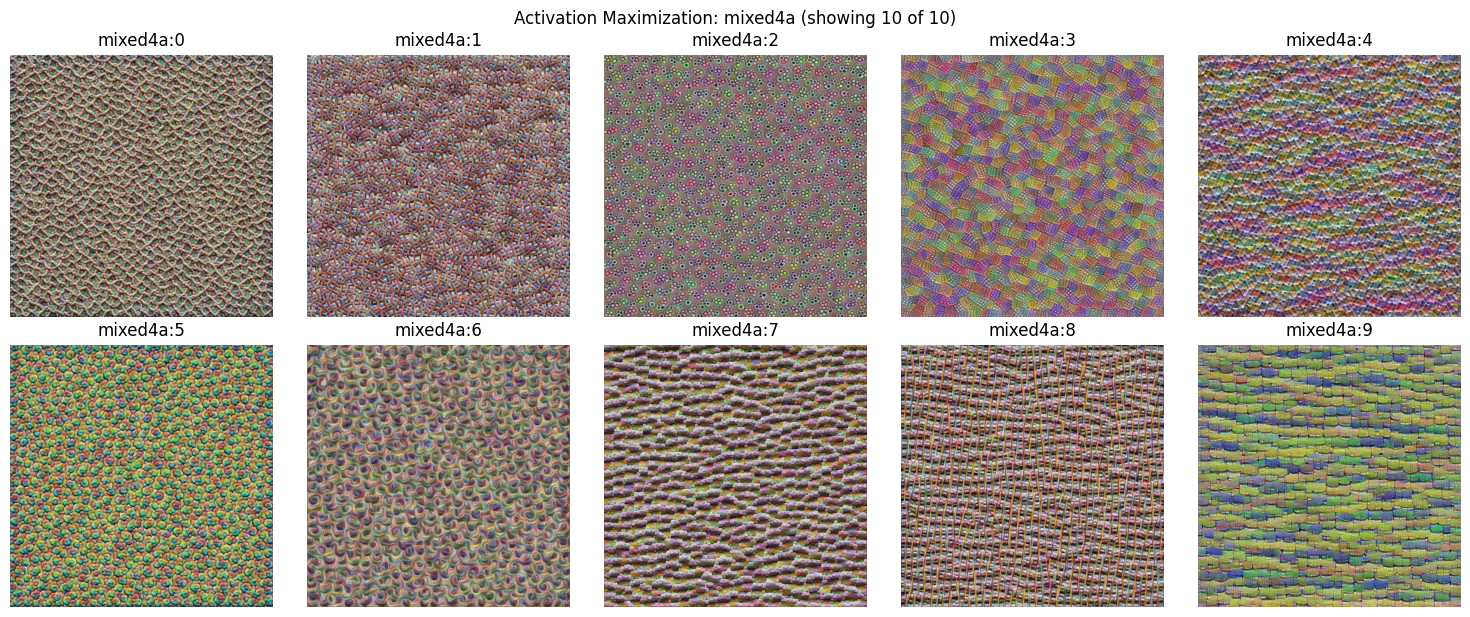


SUMMARY
  Total images generated: 10
  Images displayed above: 10

  📁 All images saved to: c:\Users\cataluna84\Documents\Workspace\VisionInterpretability\notebooks\results\mixed4a
  📊 W&B Dashboard: https://wandb.ai/cataluna84/activation-max-inceptionv1/runs/40z71upl


generation_time_sec,▁▂▂▂▂▂▃█▄▃
neuron_idx,▁▂▃▃▄▅▆▆▇█
generation_time_sec,236.10357
neuron_idx,9



W&B run finished successfully!


In [5]:
# =============================================================================
# Cell 5: Results Summary
# =============================================================================

import matplotlib.pyplot as plt

# Limit display to prevent notebook crashes
display_images = generated_images[:DISPLAY_MAX_IMAGES]
num_display = len(display_images)
total_generated = len(generated_images)

# Calculate grid dimensions
cols = min(5, num_display)
rows = (num_display + cols - 1) // cols

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
if rows == 1 and cols == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]
elif cols == 1:
    axes = [[ax] for ax in axes]

# Plot images
for idx, (neuron_idx, img, path) in enumerate(display_images):
    row, col = idx // cols, idx % cols
    axes[row][col].imshow(img)
    axes[row][col].set_title(f"{LAYER_NAME}:{neuron_idx}")
    axes[row][col].axis("off")

# Hide empty subplots
for idx in range(num_display, rows * cols):
    row, col = idx // cols, idx % cols
    axes[row][col].axis("off")

plt.tight_layout()
plt.suptitle(f"Activation Maximization: {LAYER_NAME} (showing {num_display} of {total_generated})", y=1.02)
plt.show()

# Summary
print(f"\n" + "="*60)
print(f"SUMMARY")
print(f"="*60)
print(f"  Total images generated: {total_generated}")
print(f"  Images displayed above: {num_display}")
if total_generated > num_display:
    print(f"  ⚠️  {total_generated - num_display} additional images not shown (saved to disk & W&B)")
print(f"\n  📁 All images saved to: {RESULTS_DIR}")
print(f"  📊 W&B Dashboard: {wandb.run.url}")
print(f"="*60)

# Finish W&B run
wandb.finish()
print("\nW&B run finished successfully!")